In [ ]:
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

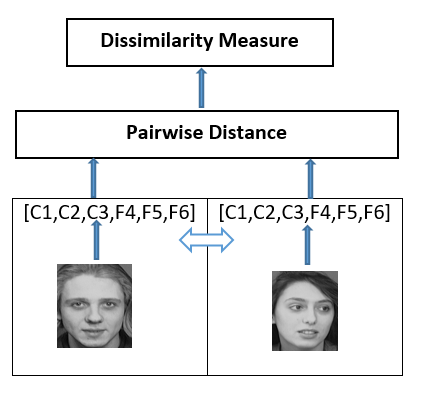

In [ ]:
class ConfigClass():
    #connect drive first
    train_dir = '/content/drive/My Drive/data/facesTrimmed/Training/'
    test_dir = '/content/drive/My Drive/data/facesTrimmed/Testing/'   
    #train_dir = './Siamese Networks/data/faces/training/'
    #test_dir = './Siamese Networks/data/faces/testing/'
    train_batch_size = 74 #max = 740
    train_num_epochs = 100

In [ ]:
class SiameseDataset(Dataset):
    #constructor
    def __init__(self, image_folder, transform = None, invert = False): 
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index): #randomly returns a pair of images (as 100*100 tensors) and label, true if they are not of the same person, false if they are
        sample_1 = random.choice(self.image_folder.imgs) #randomly get some folder eg s1
        same_class = random.randint(0, 1)#random true or false
        
        if same_class:#1
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break #when sample2 is the same folder eg s1
        else:#0
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break #when s2 is another folder other than s1
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32)) 
        #returns 2 images and a label, true if they arent from the same folder(person) false if they are.
    def __len__(self):
        return len(self.image_folder.imgs)

In [ ]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()  

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1) #Pads the input tensor using the reflection of the input boundary.
        '''
        in_channels (int) – Number of channels in the input image
        out_channels (int) – Number of channels produced by the convolution
        kernel_size (int or tuple) – Size of the convolving kernel
        stride (int or tuple, optional) – Stride of the convolution. Default: 1
        '''
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(5, 14, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(14, 60, kernel_size=3, stride=2) 
        self.relu = nn.ReLU(inplace=True)
        '''
        Normalization Layers
        Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, 
        as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, 
        and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, 
        and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture 
        and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful 
        about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout
        '''
        self.batch_norm1 = nn.BatchNorm2d(5) # 4 = number of features
        self.batch_norm2 = nn.BatchNorm2d(14)
        self.batch_norm3 = nn.BatchNorm2d(60) 
        '''
        Linear Layers
        Applies a linear transformation to the incoming data
        in_features – size of each input sample
        out_features – size of each output sample
        bias – If set to False, the layer will not learn an additive bias. Default: True
        '''
        self.fc1 = nn.Linear(60*13*13, 3200) #8 features, 100*100 is the size of the images
        self.fc2 = nn.Linear(3200, 1600)
        self.fc3 = nn.Linear(1600, 40)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x)))) #padding, conv, relu, normalise (4 outputs)
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x)))) #conv, relu, normalise (8 outputs)       
        x = self.batch_norm3(self.relu(self.conv3(self.reflection_pad(x)))) #conv, relu, normalise (8 outputs)  
        x = x.view(x.size()[0], -1) # a new pointer to x that allows us to do fast and memory efficient reshaping, slicing and element-wise operations.
        x = self.relu(self.fc1(x)) #linear transform (8 * 100 * 100) inputs , relu (500 outputs)
        x = self.relu(self.fc2(x)) #linear transform (500) inputs, relu (500 outputs)       
        x = self.fc3(x) #linear transform (500) inputs, relu (5 outputs)
        
        return x #5 output features
        
    def forward(self, input1, input2): #Forward through the siamese architecture
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2 #returns 5 output features for each image

In [ ]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True) #Computes the batchwise pairwise distance between vectors v_1v1​, v_2v2​ using the p-norm
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)) #Pair-wise ranking loss
        
        return contrastive_loss #returns the loss

3


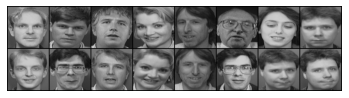

vis_batch[0] torch.Size([8, 1, 100, 100])
vis_batch[1] torch.Size([8, 1, 100, 100])
vis_batch[2] torch.Size([8, 1])
Epoch: 0 	 Loss: 0.9980941414833069
Epoch: 1 	 Loss: 0.5499900579452515
Epoch: 2 	 Loss: 0.4677429497241974
Epoch: 3 	 Loss: 0.5014594197273254
Epoch: 4 	 Loss: 0.24606269598007202
Epoch: 5 	 Loss: 0.2568516731262207
Epoch: 6 	 Loss: 0.09377235919237137
Epoch: 7 	 Loss: 0.17329880595207214
Epoch: 8 	 Loss: 0.06289295852184296
Epoch: 9 	 Loss: 0.07239507883787155
Epoch: 10 	 Loss: 0.08450896292924881
Epoch: 11 	 Loss: 0.073952317237854
Epoch: 12 	 Loss: 0.06977946311235428
Epoch: 13 	 Loss: 0.03199645131826401
Epoch: 14 	 Loss: 0.04317076504230499
Epoch: 15 	 Loss: 0.041409410536289215
Epoch: 16 	 Loss: 0.06259074062108994
Epoch: 17 	 Loss: 0.03418044000864029
Epoch: 18 	 Loss: 0.03925398737192154
Epoch: 19 	 Loss: 0.04707527160644531
Epoch: 20 	 Loss: 0.04809091240167618
Epoch: 21 	 Loss: 0.01928301714360714
Epoch: 22 	 Loss: 0.022328853607177734
Epoch: 23 	 Loss: 0.02954

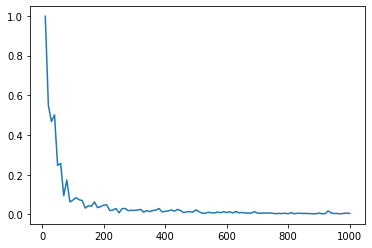

SiameseNetwork(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(5, 14, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(14, 60, kernel_size=(3, 3), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (batch_norm1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10140, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1600, bias=True)
  (fc3): Linear(in_features=1600, out_features=40, bias=True)
)


In [ ]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir) #Training dataset
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                             transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                             invert=False) #object with getItem() and len()
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8) #gives a batch of 8 pairs of randomly matched faces and labels
'''
Dataset object to load data from
num_workers -  multi-process data loading
A sequential or shuffled sampler will be automatically constructed based on the shuffle
batch_size = automatically collating individual fetched data samples into batches
'''
data_iter = iter(dataloader)
vis_batch = next(data_iter)
print(len(vis_batch)) #= torch.Size([8, 1, 100, 100])
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged)) #prints the first grid of pairs.
vis_batch[2].numpy() #8 labels
print("vis_batch[0]",vis_batch[0].size())
print("vis_batch[1]",vis_batch[1].size())
print("vis_batch[2]",vis_batch[2].size())

#dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=ConfigClass.train_batch_size)

'''
batch_size random pairs of faces from the 37 individuals (batch_size is the size of our training dataset)
'''
model = SiameseNetwork().cuda()
criterion = ConstrastiveLoss() #used to calculate how wrong the model is
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
#To use torch.optim you have to construct an optimizer object, that will hold the current state and will update the parameters based on the computed gradients.

counter = []
loss_history = []
iteration = 0



for epoch in range(ConfigClass.train_num_epochs): #for each epoch we go through the whole batch size
    dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=30, batch_size=ConfigClass.train_batch_size)
    for i, data in enumerate(dataloader, 0): #does o74 abaw10
        input1, input2, label = data #image 1, image 2 and label
        

        
        #print("input1.size() on i", i, input1.size()) #= [64, 1, 100, 100]
        #print("label.size()", label.size()) = [64, 1]
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        #This package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation
        optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation
        output1, output2 = model(input1, input2)#forward pass
        contrastive_loss = criterion(output1, output2, label)#determines the distance between the 2 represantations and returns a loss
        contrastive_loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update)
    print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
    iteration += 10
    loss_history.append(contrastive_loss.item())
    counter.append(iteration)
            
show_plot(counter, loss_history)
print(model)

In [ ]:
import os
from itertools import combinations 

imageDirName = []
subDirectories = os.listdir(ConfigClass.test_dir)

for i, person in enumerate(subDirectories):
  imageNames = os.listdir(ConfigClass.test_dir+"/"+person)
  for imageName in imageNames:
    imageDirName.append((person, imageName))

#861 PAIRS
comb = combinations(imageDirName,2)
transTensor =  transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

#transTensor = transforms.ToTensor()

y = []
distances = []
for pairTupples in list(comb):
  #print(pairTupples)
  #print((ConfigClass.test_dir+pairTupples[0][0]+"/"+pairTupples[0][1]))
  #print(ConfigClass.test_dir+pairTupples[1][0]+"/"+pairTupples[1][1])
  img1 = Image.open(ConfigClass.test_dir+"/"+pairTupples[0][0]+"/"+pairTupples[0][1]).convert("L")
  img2 = Image.open(ConfigClass.test_dir+pairTupples[1][0]+"/"+pairTupples[1][1]).convert("L")
  img1 = transTensor(img1)
  img2 = transTensor(img2)
  img1 = img1[None, :, :, :]
  img2 = img2[None, :, :, :]
  label = 0
  if pairTupples[0][0] == pairTupples[1][0]:
    label = 1
  #print(label)
  y.append(label)
  output1, output2 = model(img1.cuda(), img2.cuda())
  #Get dissimilarity distance
  distance = F.pairwise_distance(output1, output2)
  #print(distance.item())
  distances.append(distance.item())

disNormalized = []
for k in range(len(distances)):
  disN = (distances[k] - min(distances))/ (max(distances) - min(distances))
  #print(distances[i], disN, y[i])
  disNormalized.append(disN)

In [ ]:
#0.01 - 1
thresholds = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0]
FACounts = []
FRCounts = []
TPCounts = []
TNCounts = []
accPerThresh = []
for thresh in thresholds:
  countFA = 0
  countFR = 0
  TPCount = 0
  TNCount=0
  yHat = []
  acc = 0
  for i, disN in enumerate(disNormalized):
    if disN < thresh:
      yHat.append(1)
      if y[i]==0:
        countFA +=1
      else:
        TPCount +=1
    else:
      yHat.append(0)
      if y[i]==1:
        countFR +=1
      else:
        TNCount+=1
  acc = accuracy_score(y, yHat)
  accPerThresh.append(acc * 100)
  #FACounts.append((countFA/len(disNormalized))*100)
  #FRCounts.append((countFR/len(disNormalized))*100)
  FACounts.append(countFA)
  FRCounts.append(countFR)
  TPCounts.append(TPCount)
  TNCounts.append(TNCount)
TPRate = []
FPRate = []
FNRate = []
for i in range(len(thresholds)):
  TPRate.append(TPCounts[i] / (TPCounts[i] + FRCounts[i]))
  FPRate.append(FACounts[i] / (FACounts[i] + TNCounts[i]))
  FNRate.append(1 - TPRate[i])
ThreshAtEER = 0
EER = 0
for i in range(len(thresholds)):
  thresh = thresholds[i]
  
  #print(round(FPRate[i],2), round(FNRate[i],2))
  if round(FPRate[i],2) == round(FNRate[i],2):
    ThreshAtEER = thresh
    EER = FPRate[i]
    #break
print("EER:",EER)
print("Threshold at EER", ThreshAtEER)


EER: 0.0735930735930736
Threshold at EER 0.3




*   FAR is the likelihood of the model incorrectly accepting an imposter pair
*   FRR is the likelihhod of the model to incorrectly rejecting a genuine sample.
*   EER is the value when FAR is equal to FRR (Low EER is best)



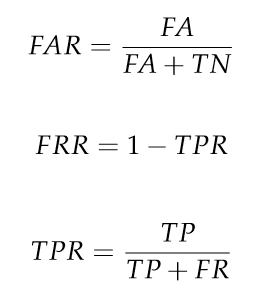

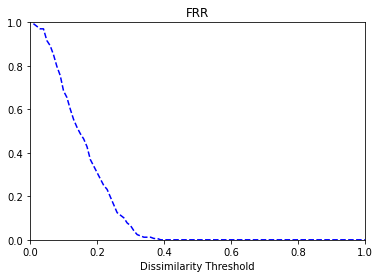

<Figure size 432x288 with 0 Axes>

In [ ]:
TPRate = np.array(TPRate)
FNRate = np.array(FNRate)
plt.plot(thresholds,FNRate,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('FRR')
plt.axis([0, 1, 0, 1])
plt.show()
fileName2 = "FRRfullface.png" 
plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

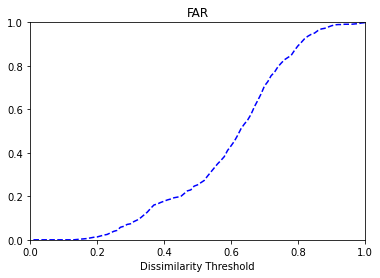

<Figure size 432x288 with 0 Axes>

In [ ]:
FPRate = np.array(FPRate)
plt.plot(thresholds,FPRate,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('FAR')
plt.axis([0, 1, 0, 1])
plt.show()
fileName2 = "FARfullface.png" 
plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

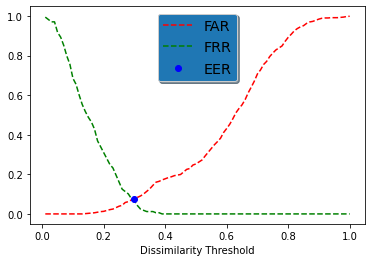

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

ax.plot(thresholds, FPRate, 'r--', label='FAR')
ax.plot(thresholds, FNRate, 'g--', label='FRR')
plt.xlabel('Dissimilarity Threshold')
plt.plot(ThreshAtEER,EER,'bo', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()
fileName2 = "EERfullface.png" 
plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

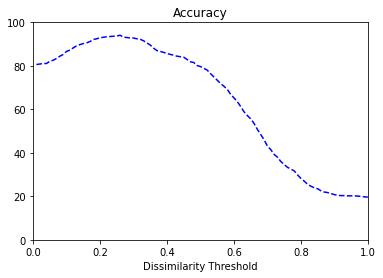

<Figure size 432x288 with 0 Axes>

In [ ]:
accPerThresh = np.array(accPerThresh)
plt.plot(thresholds,accPerThresh,'--b')
plt.xlabel('Dissimilarity Threshold')
plt.title('Accuracy')
plt.axis([0, 1, 0, 100])
plt.show()
fileName2 = "Accuracyfullface.png" 
plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)

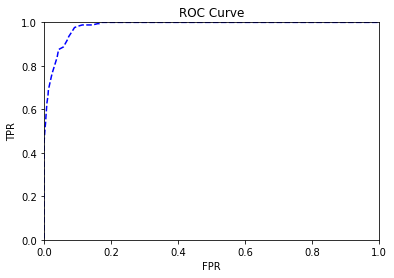

<Figure size 432x288 with 0 Axes>

In [ ]:
#print(TPRate)
#print(FPRate)
plt.plot(FPRate,TPRate,'--b')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.axis([0, 1, 0, 1])

#plt.plot([0, 1], [0, 1], transform=ax.transAxes)
#plt.axline((1, 1), slope=-1)
plt.show()
fileName2 = "ROCfullface.png" 
plt.savefig("/content/drive/MyDrive/SupFiles/AREEReyes"+fileName2)